## All Imports

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.stats import entropy
import airr
import json
import itertools
from kneed import KneeLocator
from itertools import combinations

In [36]:
hannanlab_dir = '/mnt/md0/Projects/HannanLab/KidneyTCR/'
vdjpipe_dir_33 = hannanlab_dir + '9251db8a-f7ec-45a6-8f3b-79f25232154c-007/' #
vdjpipe_dir_34 = hannanlab_dir + '6c3d5355-4429-4431-be5b-51162af8b849-007/' #91ca4180-37bd-4d93-aa7b-4425deee0b95

# Specify the directory path where you would like to save your figures
fig_dir = 'Figures/'
# Create the directory if it doesn't exist
os.makedirs(fig_dir, exist_ok=True)
print(f"Directory '{fig_dir}' is created or already exists.")

Directory 'Figures/' is created or already exists.


## VDJPipe Processing

In [37]:

#read vdjpipe summary
vdj_pipe_33 = pd.read_csv(f'{vdjpipe_dir_33}/vdjpipe_summary.csv')
vdj_pipe_34 = pd.read_csv(f'{vdjpipe_dir_34}/vdjpipe_summary.csv')
#separate sample_id from filename
vdj_pipe_33['sample_id'] = vdj_pipe_33['file'].str.split('_').str[0]
vdj_pipe_34['sample_id'] = vdj_pipe_34['file'].str.split('_').str[0]

#separate subject/patient id for later calculation
vdj_pipe_33['patient_id'] = vdj_pipe_33['sample_id'].str.split('-').str[0]
vdj_pipe_34['patient_id'] = vdj_pipe_34['sample_id'].str.split('-').str[0]
#keeping both sample number and s number for some duplicate sample_ids as they were resequenced
vdj_pipe_33['sample_snumber'] = vdj_pipe_33['sample_id'] + "_" + vdj_pipe_33['file'].str.split('_').str[1]
vdj_pipe_34['sample_snumber'] = vdj_pipe_34['sample_id'] + "_" + vdj_pipe_34['file'].str.split('_').str[1]


#set which library each data from
vdj_pipe_33['library'] = 'library_33'
vdj_pipe_34['library'] = 'library_34'

#calculating percentage of reads that passed the filter
vdj_pipe_33['% Pass'] = (vdj_pipe_33['filtered reads'] / vdj_pipe_33['merged reads']) * 100
vdj_pipe_34['% Pass'] = (vdj_pipe_34['filtered reads'] / vdj_pipe_34['merged reads']) * 100
#calculating percentage of unique reads
vdj_pipe_33['% Unique'] = (vdj_pipe_33['unique reads'] / vdj_pipe_33['filtered reads']) * 100
vdj_pipe_34['% Unique'] = (vdj_pipe_34['unique reads'] / vdj_pipe_34['filtered reads']) * 100

vdj_pipe_combined = pd.concat([vdj_pipe_33, vdj_pipe_34])
vdj_pipe_combined


,file,input reads,merged reads,length_filter,quality_filter,homopolymer_filter,match1,match2,match3,filtered reads,unique reads,sample_id,patient_id,sample_snumber,library,% Pass,% Unique
0,101-1_S1_R1_001.fastq.merged.summary.txt,214480,214479,133816,34757,367,NaN,NaN,NaN,59615,50425,101-1,101,101-1_S1,library_33,27.795262,84.584417
1,101-2_S2_R1_001.fastq.merged.summary.txt,254703,254701,192344,33279,767,NaN,NaN,NaN,46991,41965,101-2,101,101-2_S2,library_33,18.449476,89.304335
2,101-3_S3_R1_001.fastq.merged.summary.txt,243155,243154,193176,30669,731,NaN,NaN,NaN,37115,32553,101-3,101,101-3_S3,library_33,15.263989,87.708474
3,103-1_S4_R1_001.fastq.merged.summary.txt,132744,132744,110095,21463,376,NaN,NaN,NaN,14716,13049,103-1,103,103-1_S4,library_33,11.086000,88.672194
4,103-2_S5_R1_001.fastq.merged.summary.txt,315607,315606,263594,39058,1118,NaN,NaN,NaN,37992,33327,103-2,103,103-2_S5,library_33,12.037794,87.721099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,125-4_S34_R1_001.fastq.merged.summary.txt,3945,3945,3221,185,34,NaN,NaN,NaN,612,602,125-4,125,125-4_S34,library_34,15.513308,98.366013
44,126-1_S35_R1_001.fastq.merged.summary.txt,2713,2713,2121,425,162,NaN,NaN,NaN,362,360,126-1,126,126-1_S35,library_34,13.343163,99.447514
45,126-2_S36_R1_001.fastq.merged.summary.txt,3480,3479,2838,500,145,NaN,NaN,NaN,397,393,126-2,126,126-2_S36,library_34,11.411325,98.992443
46,126-3_S37_R1_001.fastq.merged.summary.txt,2410,2410,2013,137,35,NaN,NaN,NaN,340,303,126-3,126,126-3_S37,library_34,14.107884,89.117647


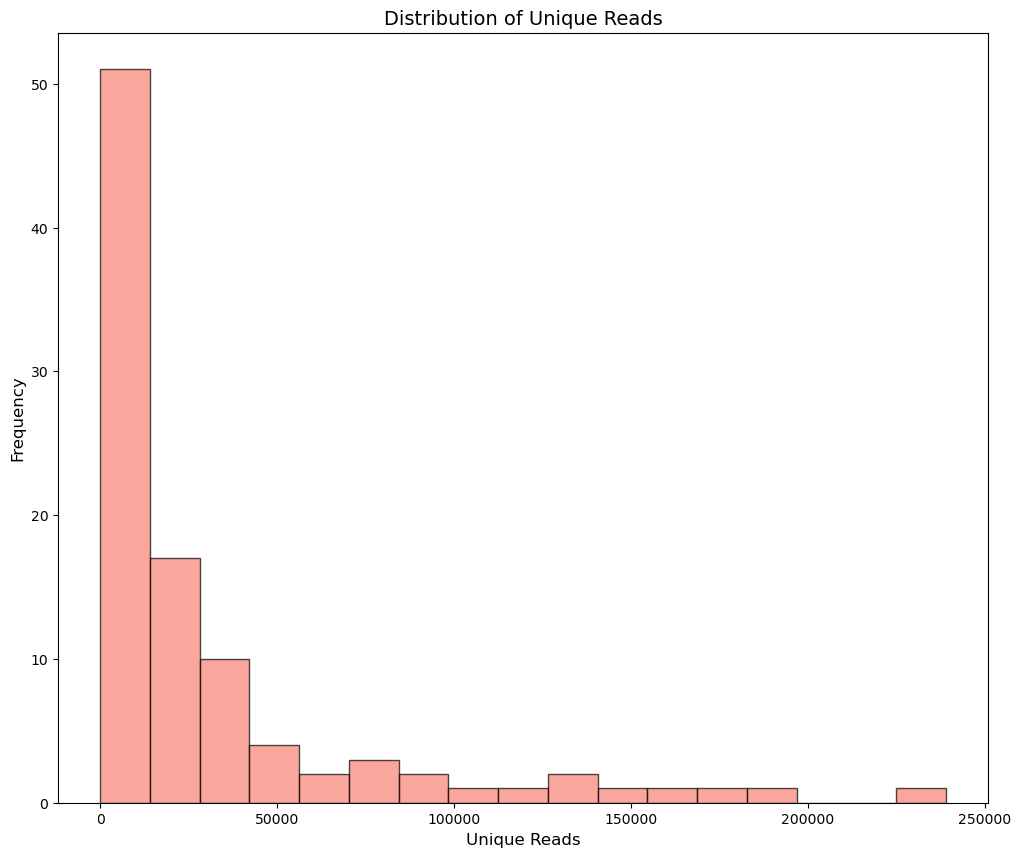

In [34]:
# # plt.hist(vdj_pipe_combined['unique reads'])
# # plt.show()

unique_reads = vdj_pipe_combined['unique reads'].tolist()

# # Create a histogram
plt.figure(figsize=(12, 10))
plt.hist(unique_reads, bins=100, color='salmon', edgecolor='black', alpha=0.7)

# Adding titles and labels
plt.title('Distribution of Unique Reads', fontsize=14)
plt.xlabel('Unique Reads', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
figname = fig_dir + f'unique_distribution_barplot.png'
plt.savefig(figname, bbox_inches='tight', dpi=300)
# Show the plot
plt.show()
# # vdj_pipe_combined[['unique reads', 'library']]

# # Create a boxplot
# plt.figure(figsize=(8, 10))
# sns.boxplot(x='library', y='unique reads', data=vdj_pipe_combined, showfliers = False)
# sns.stripplot(x = 'library', y = 'unique reads', data=vdj_pipe_combined, color='black', legend = False)
# # Add titles and labels
# plt.title('Distribution of Unique Reads by Library with Outlier', fontsize=14)
# plt.xlabel('Library', fontsize=12)
# plt.ylabel('Unique Reads', fontsize=12)
# figname = fig_dir + f'unique_distribution_with_outlier.png'
# plt.savefig(figname, bbox_inches='tight', dpi=300)

# # Show the plot
# plt.show()

## For Each Patient Find Number of Reads Pre-QC, Post QC (VDJPipe Stats)

960098


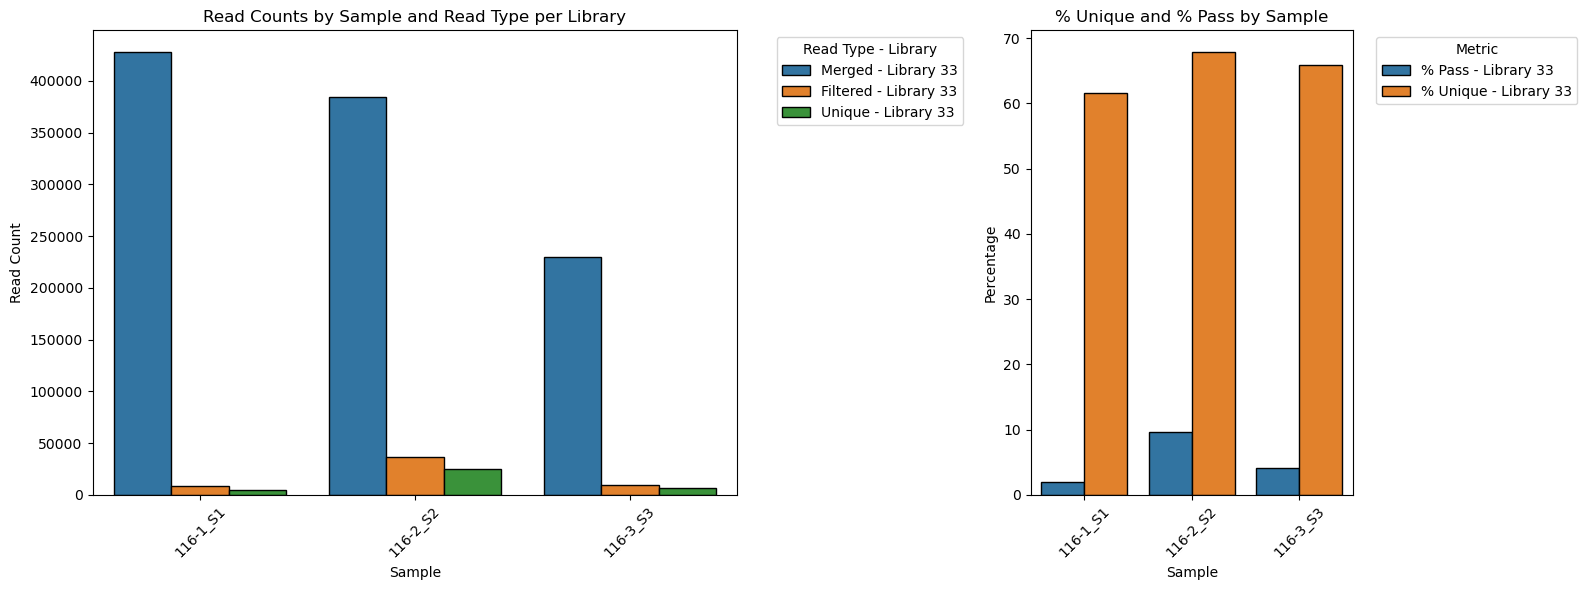

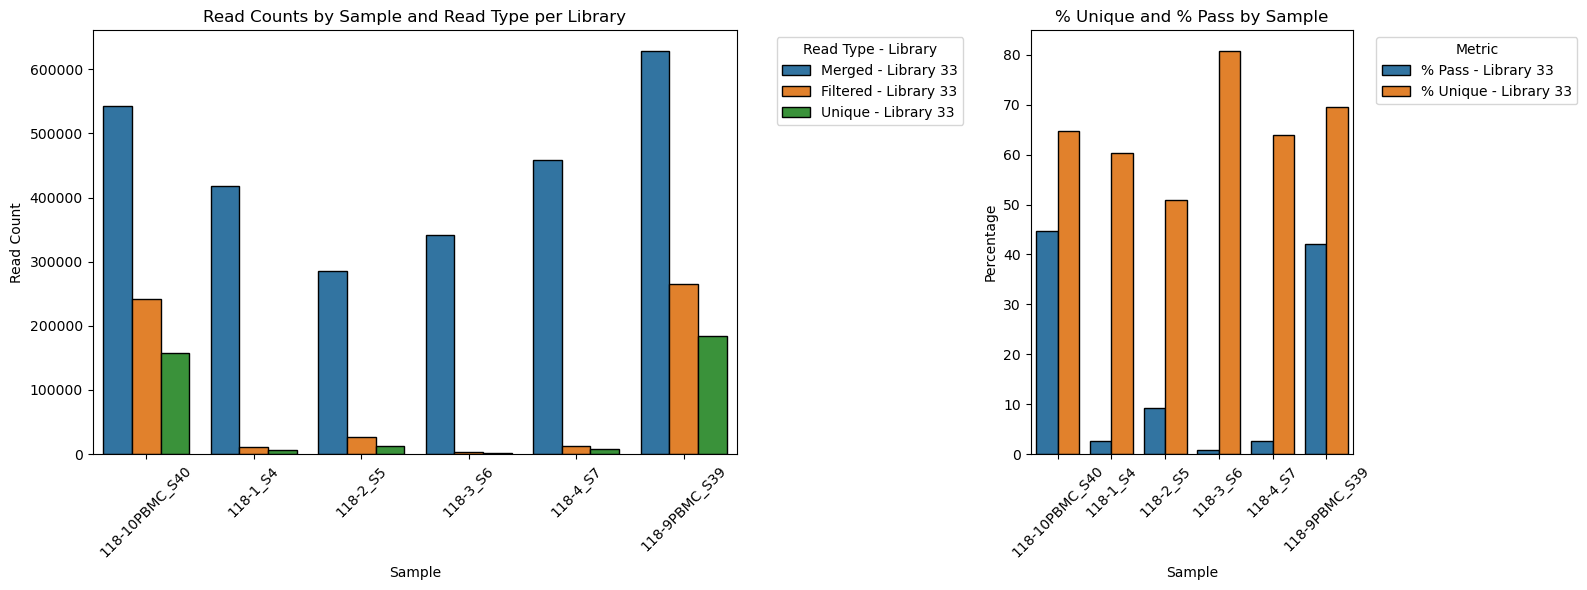

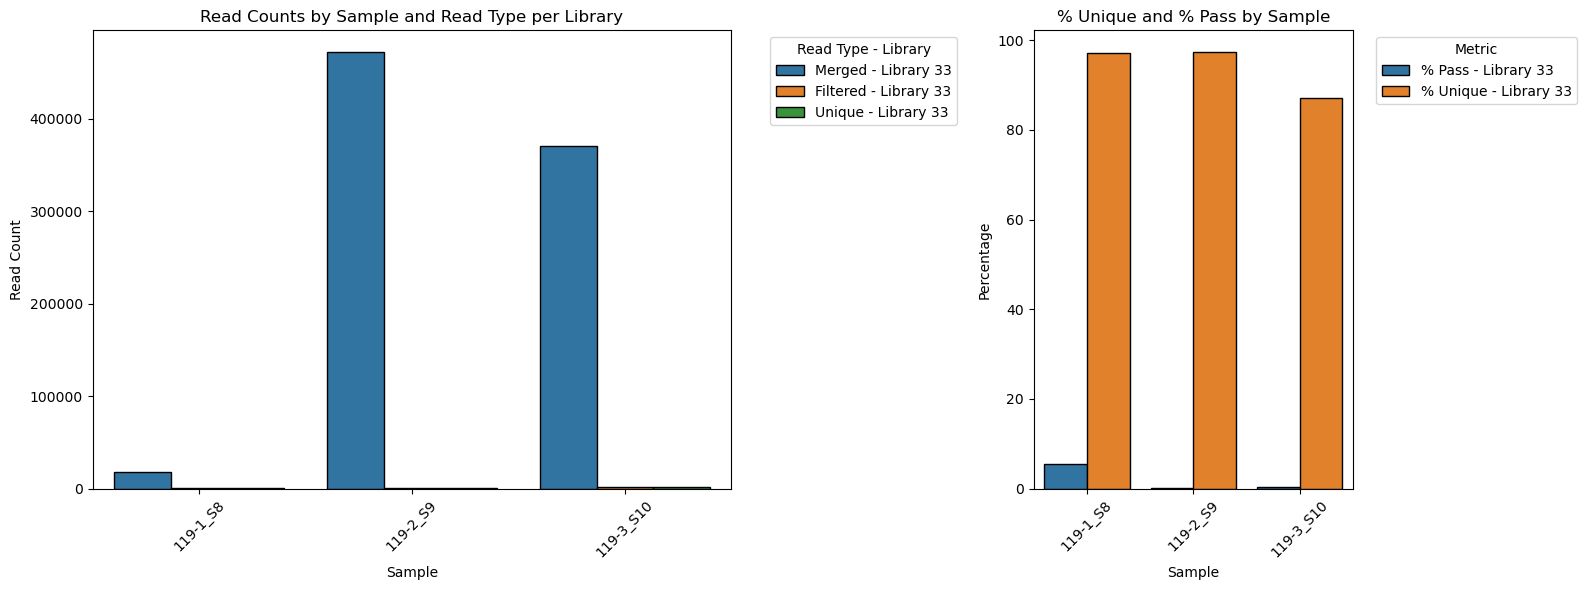

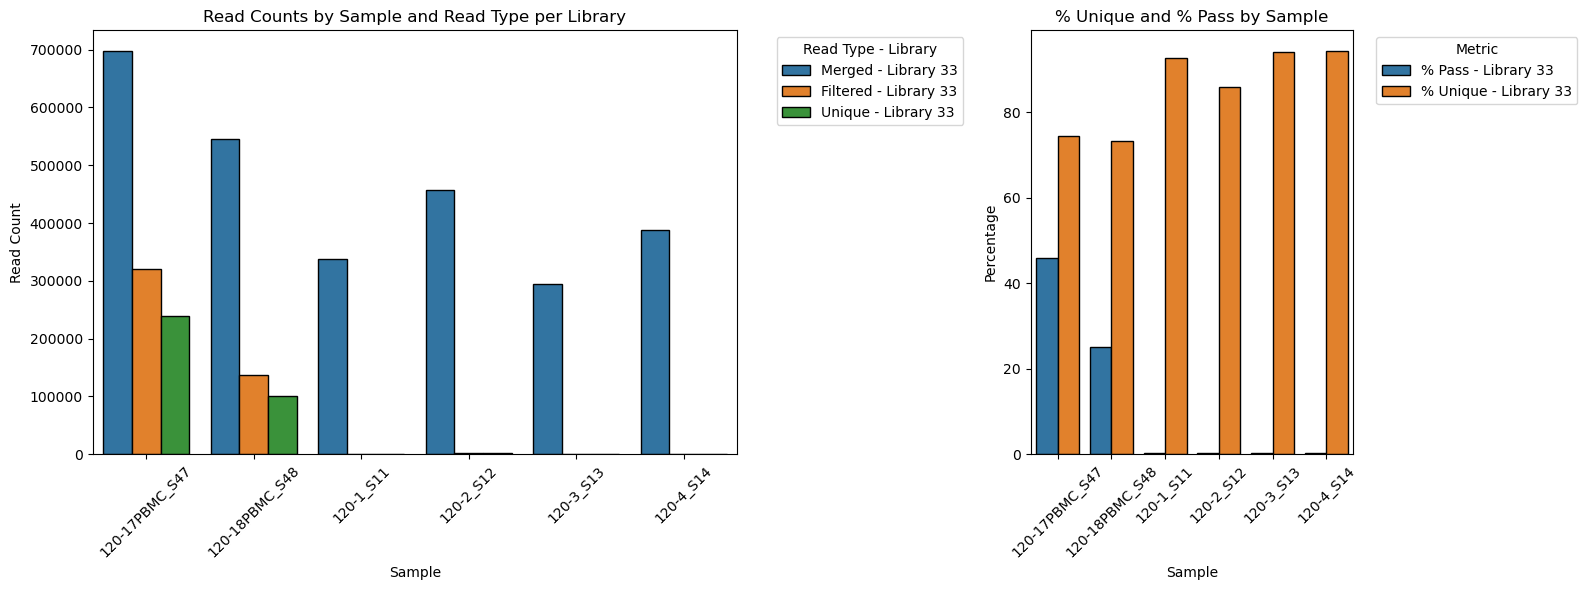

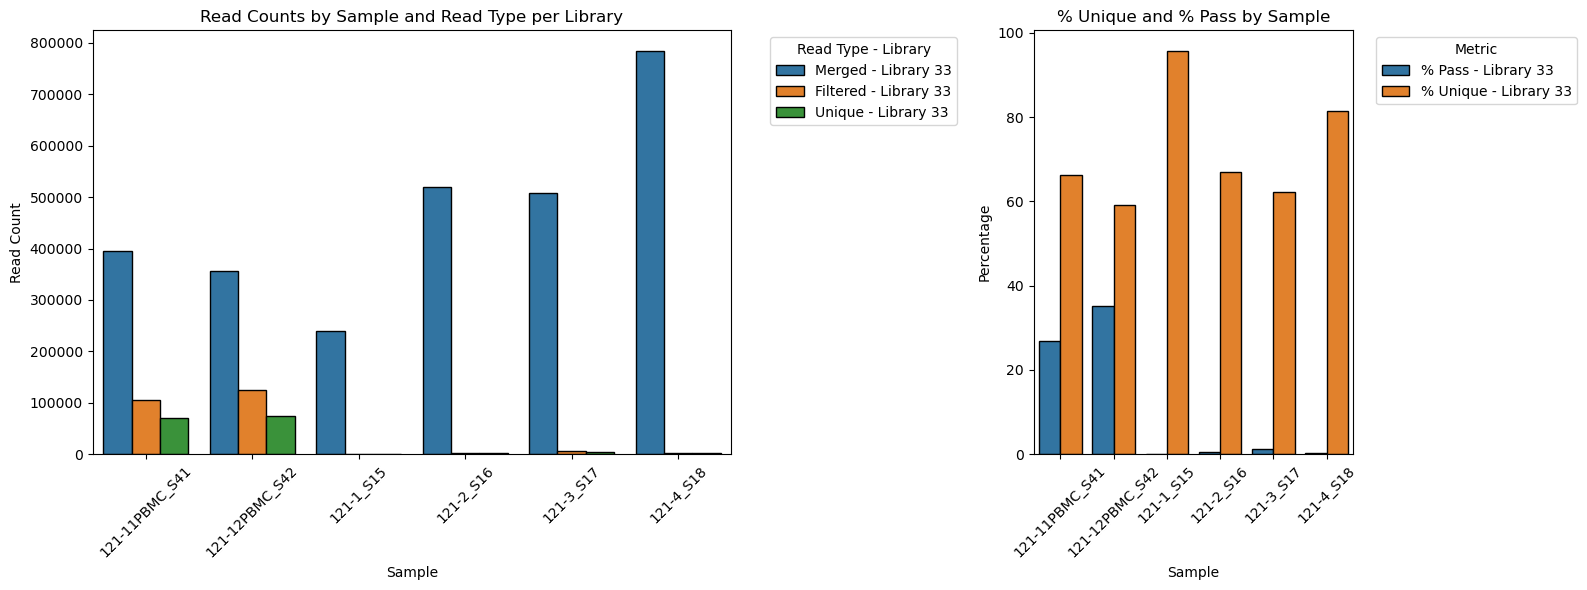

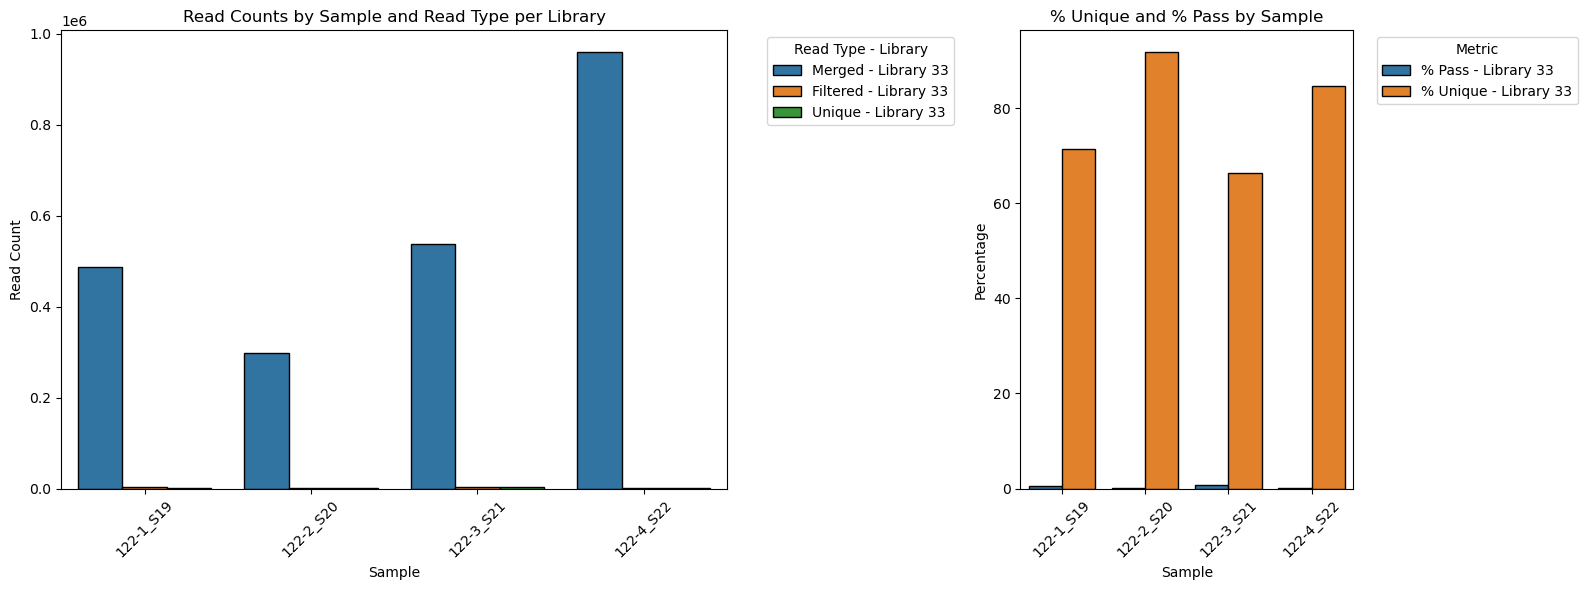

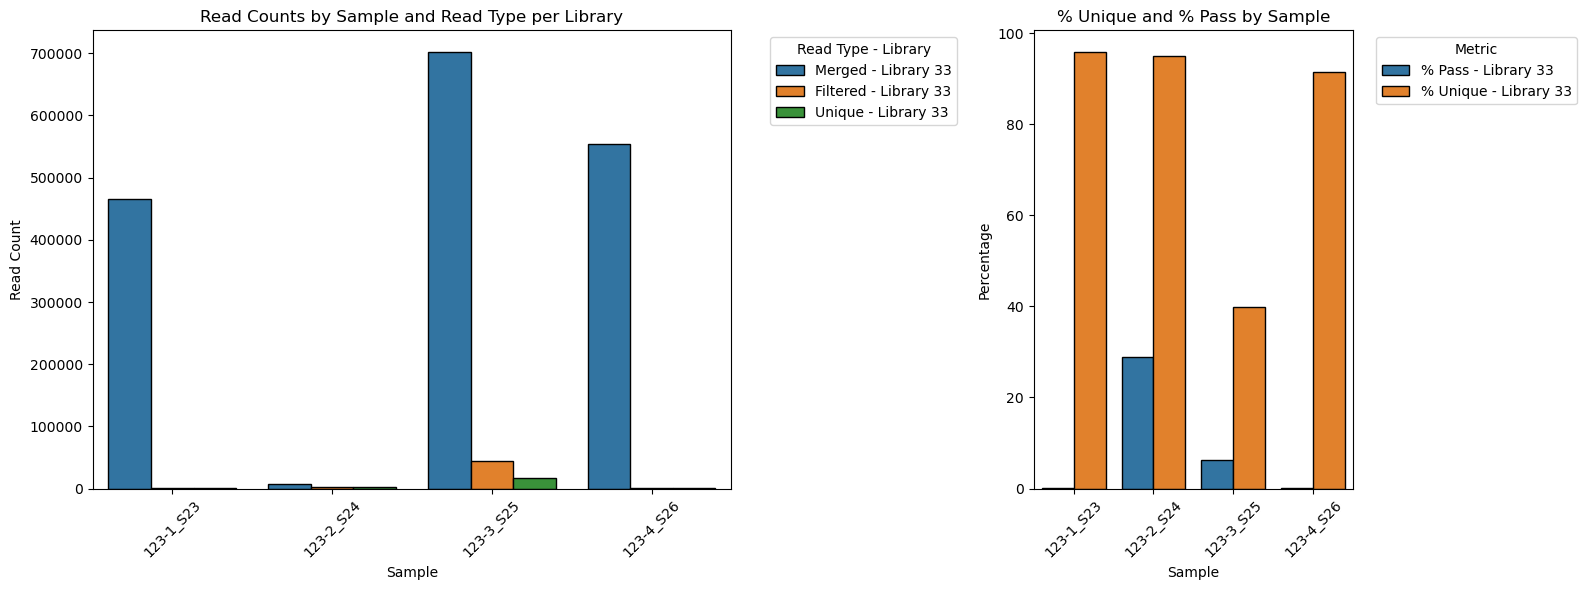

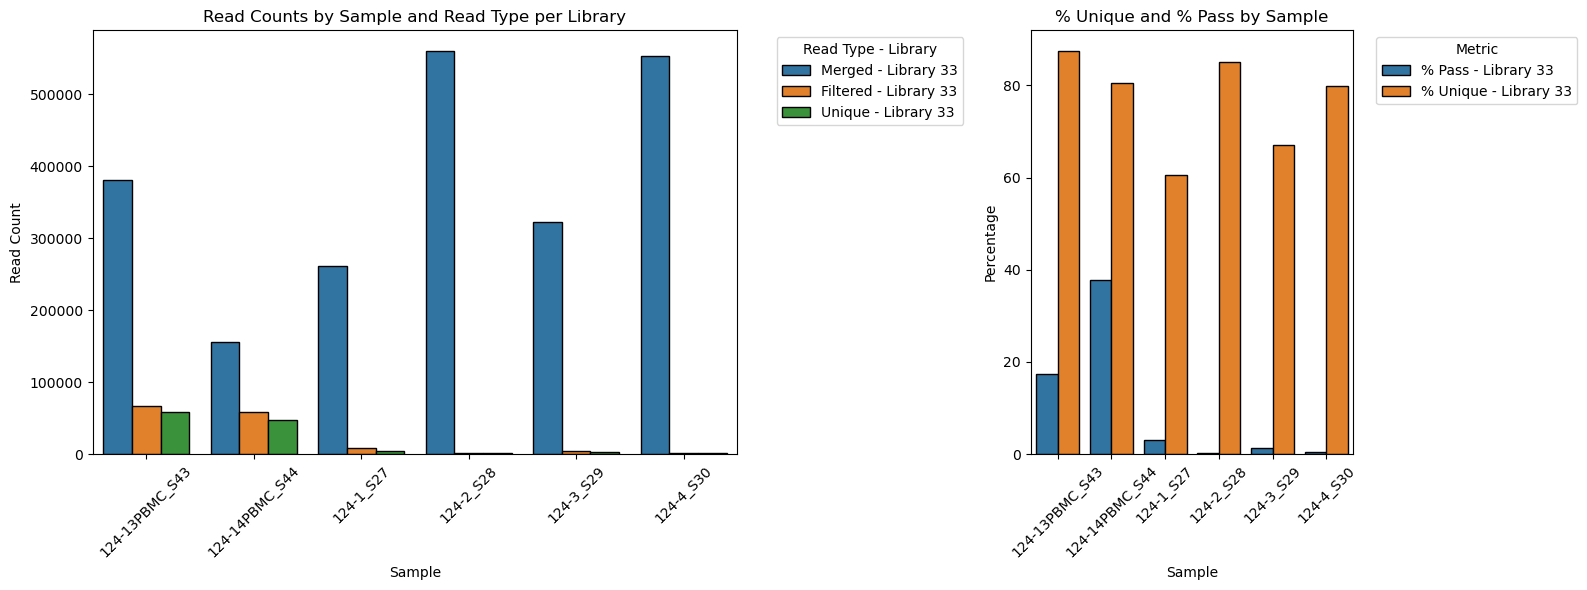

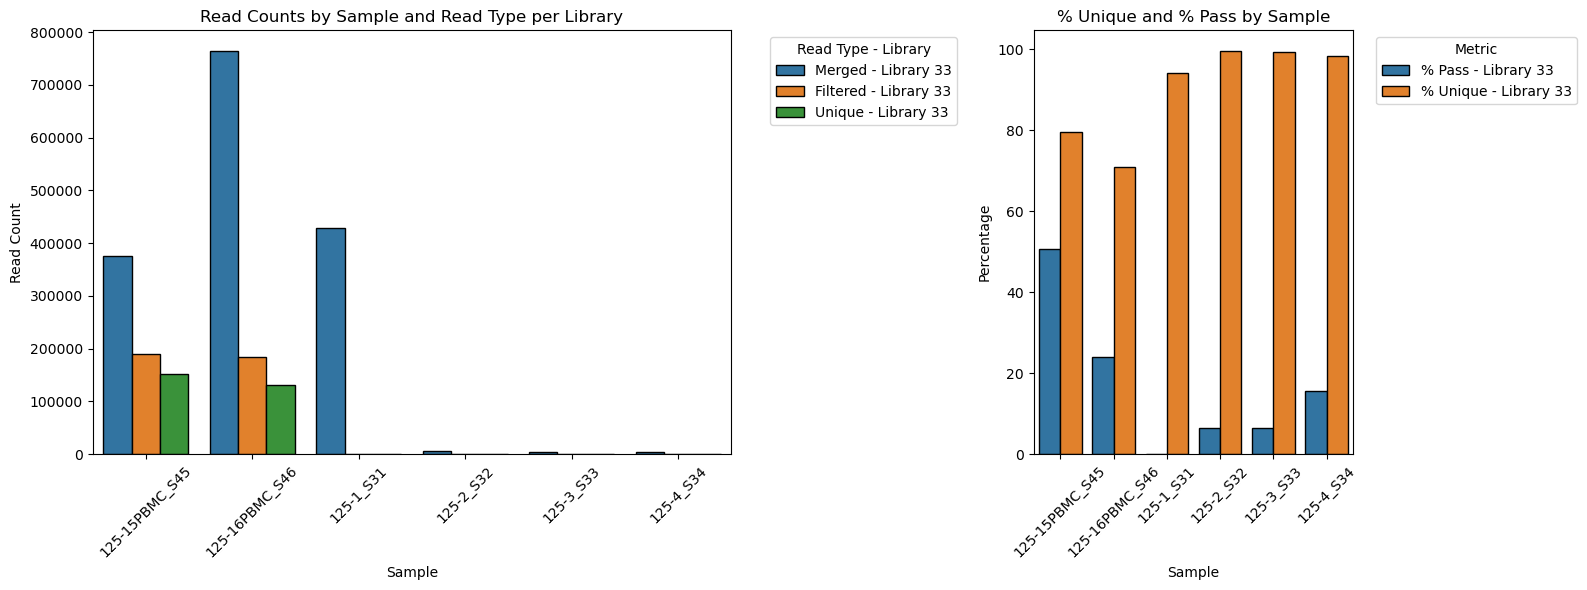

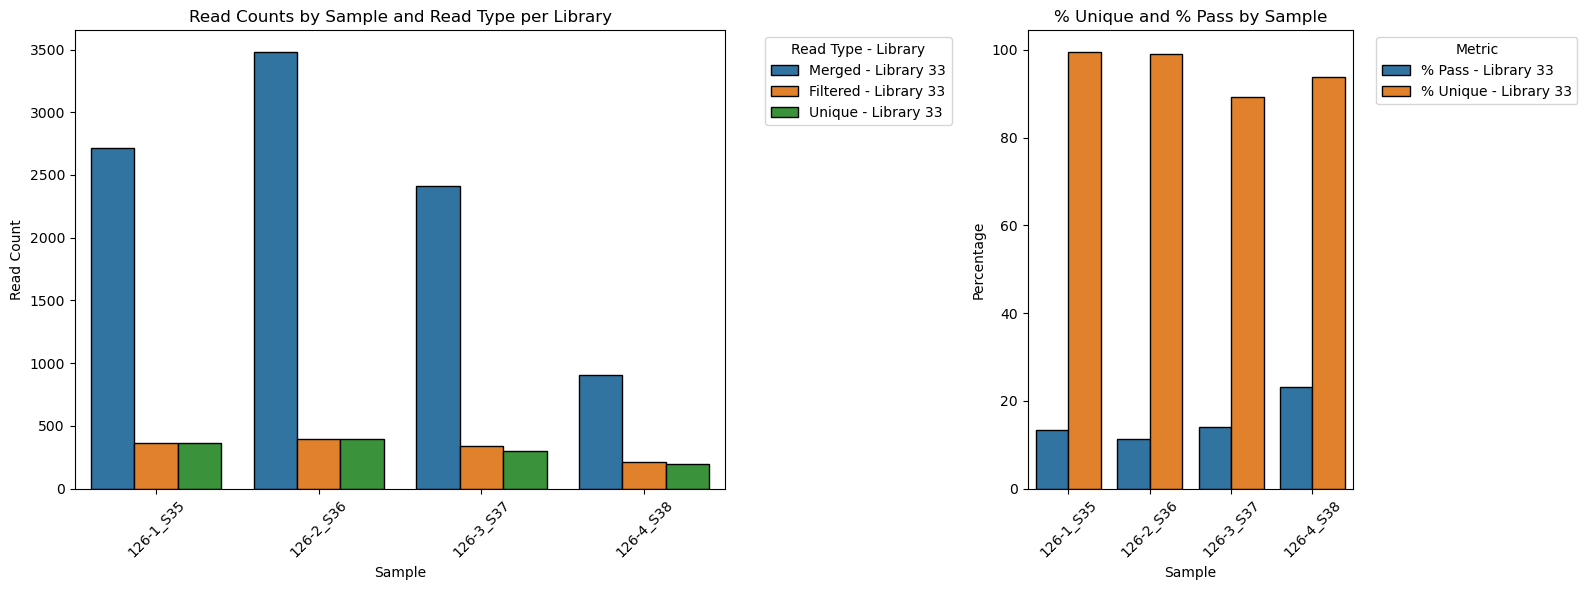

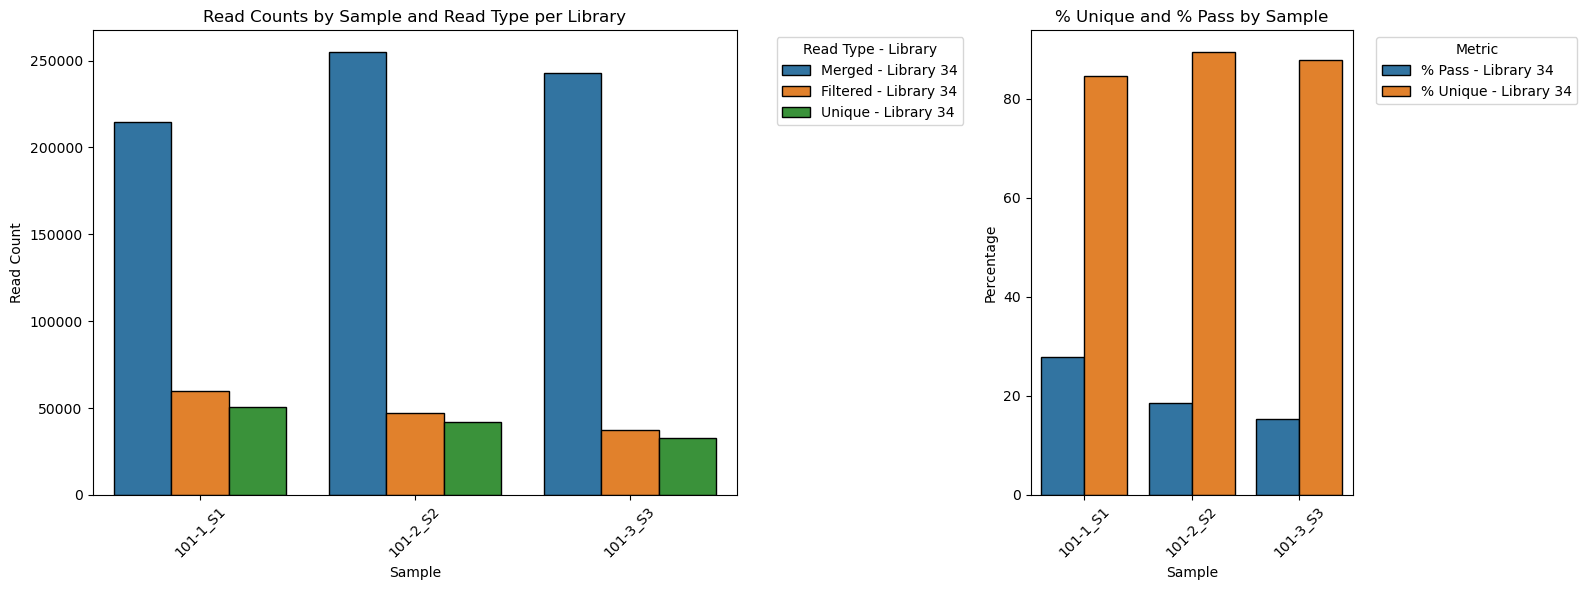

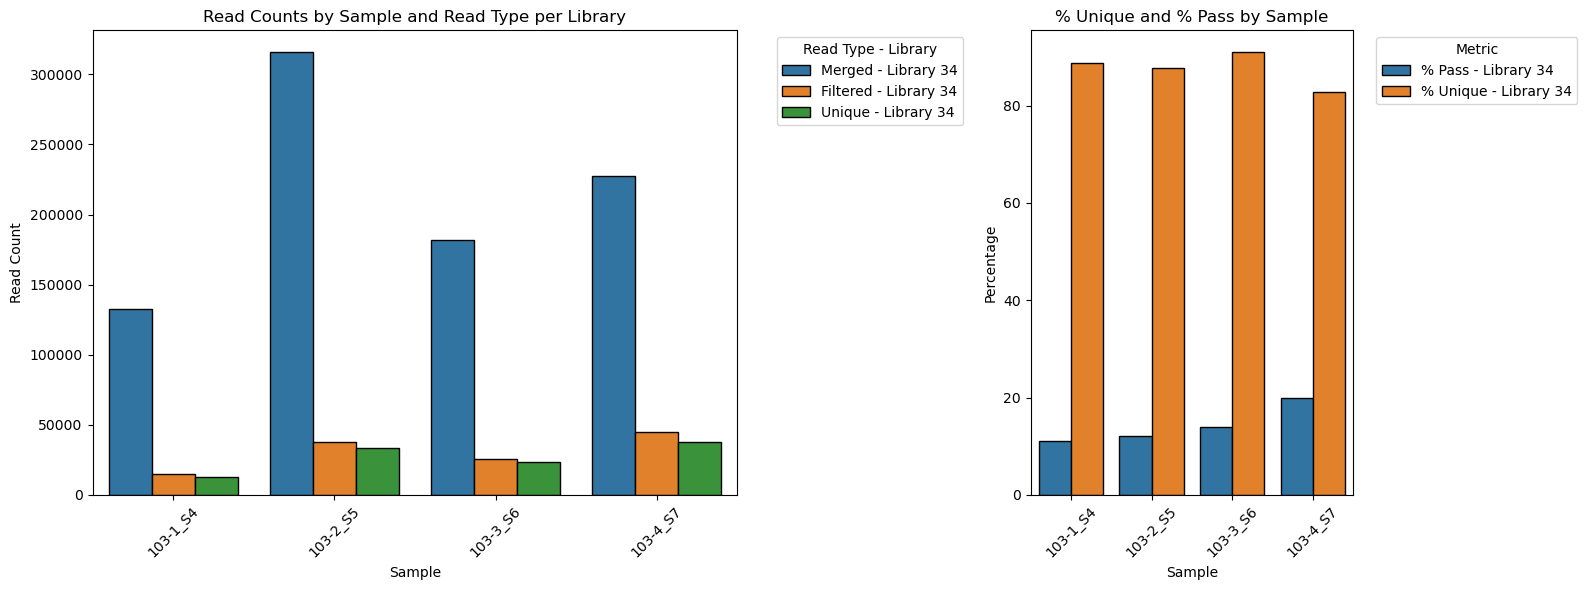

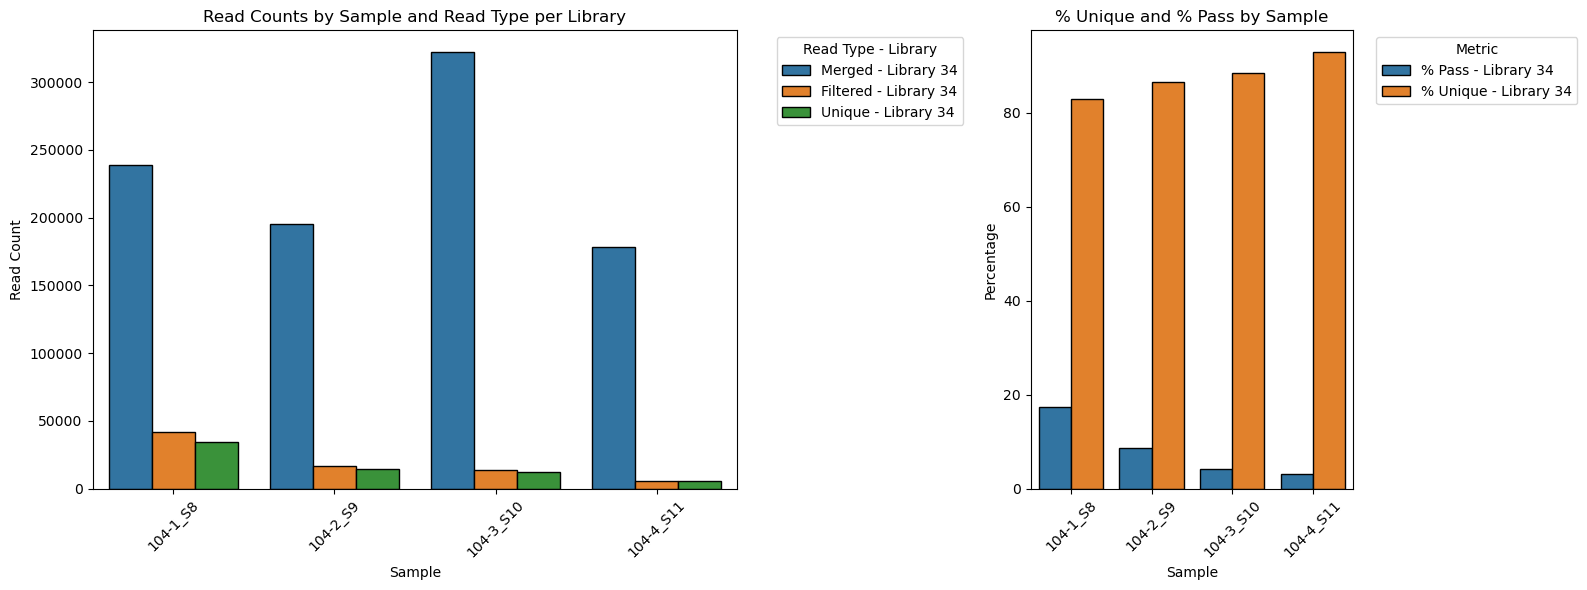

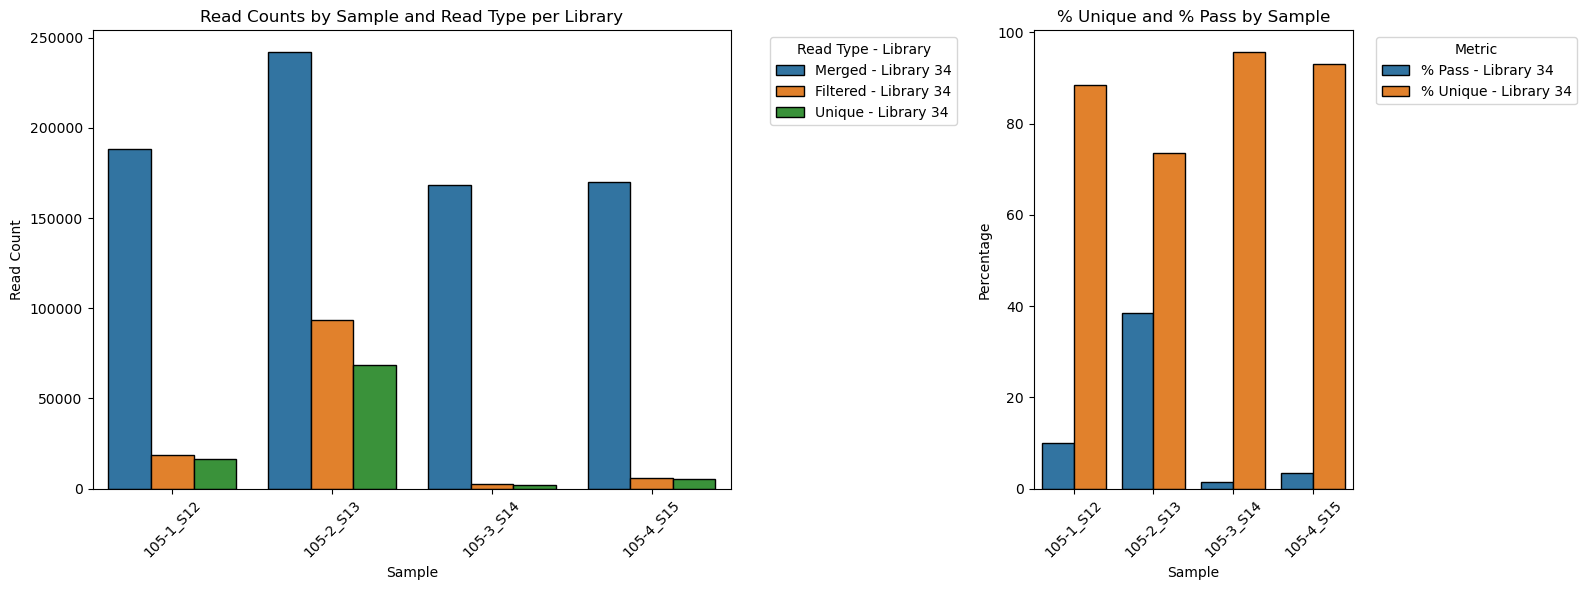

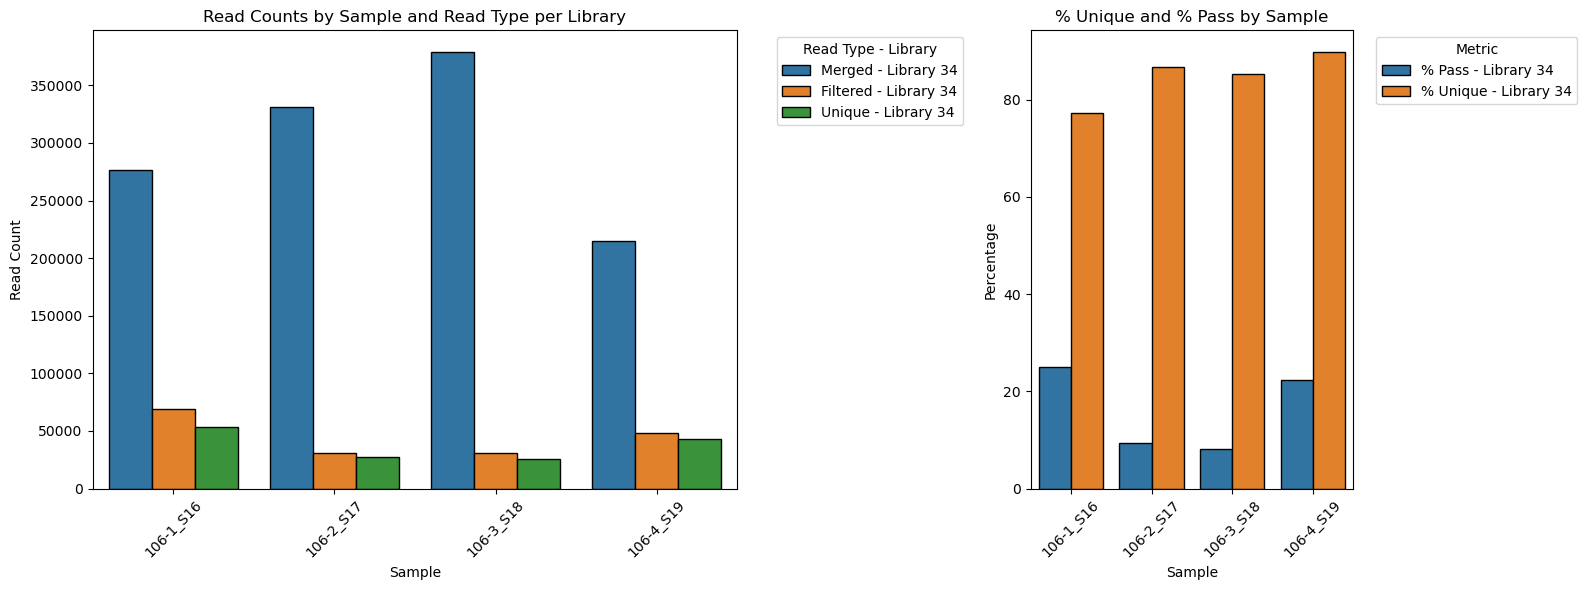

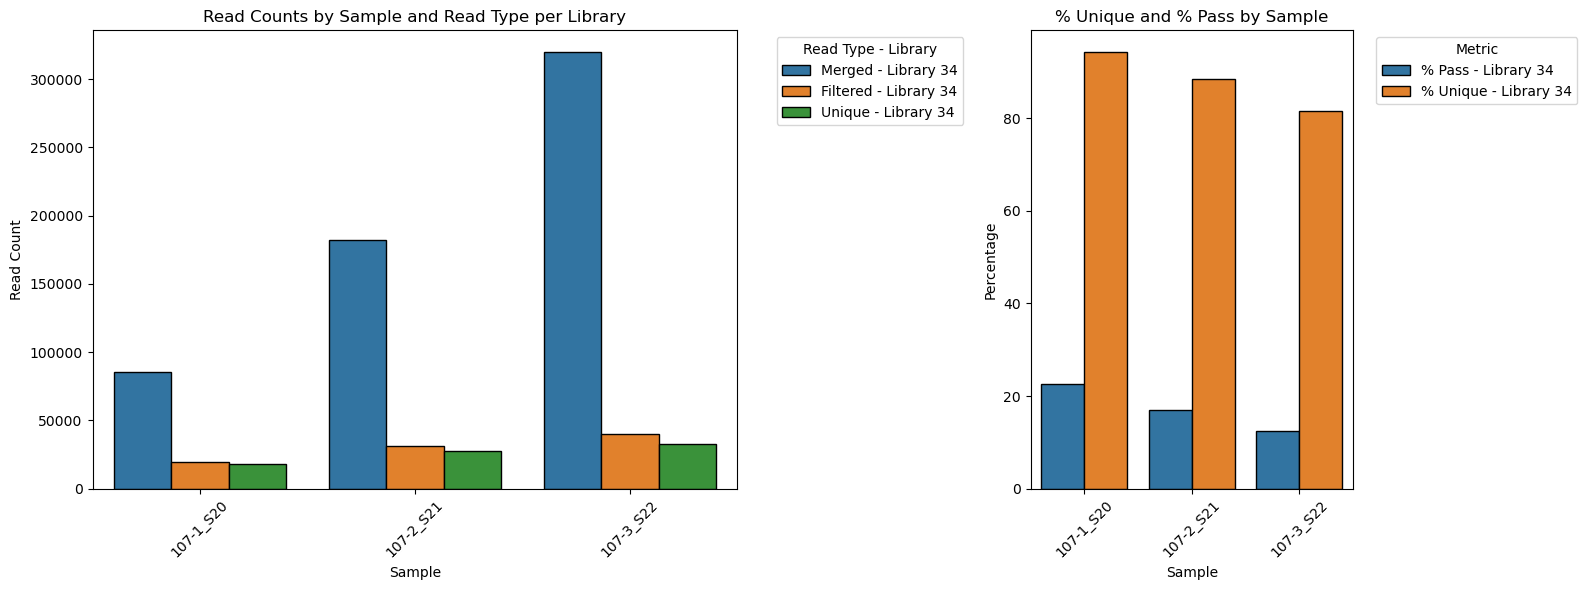

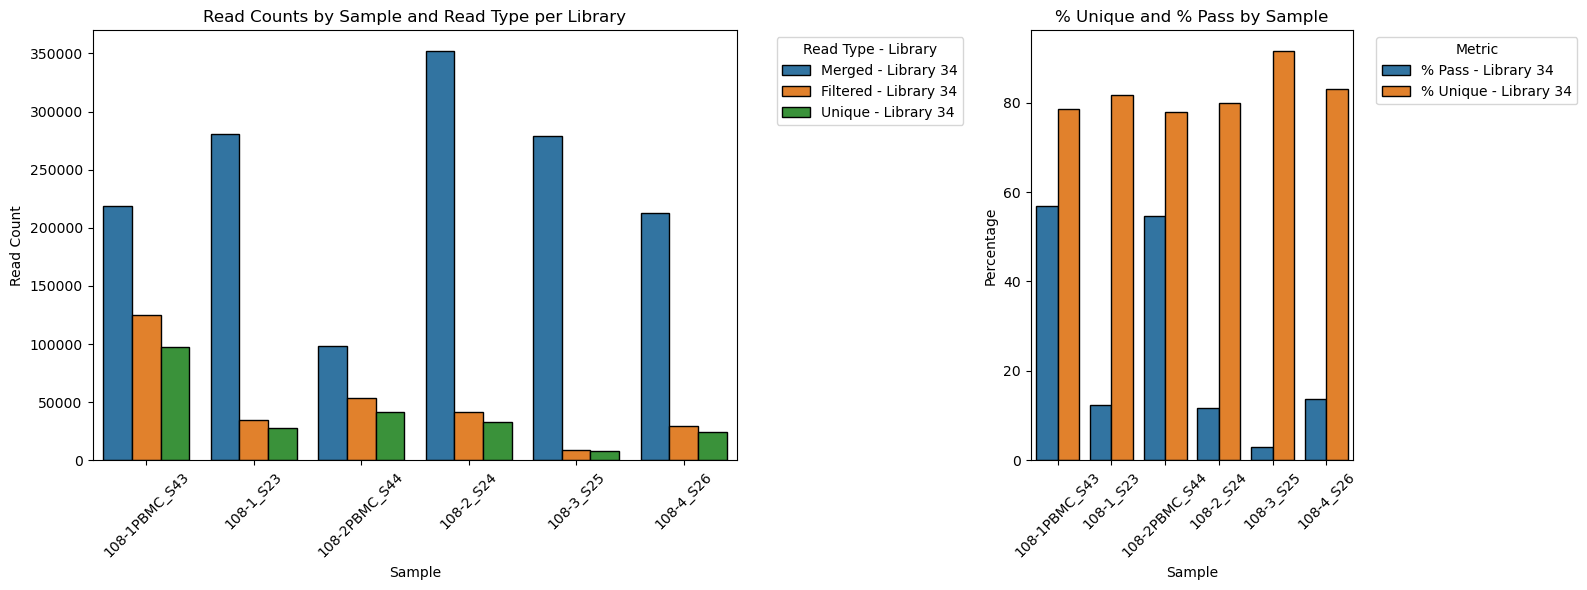

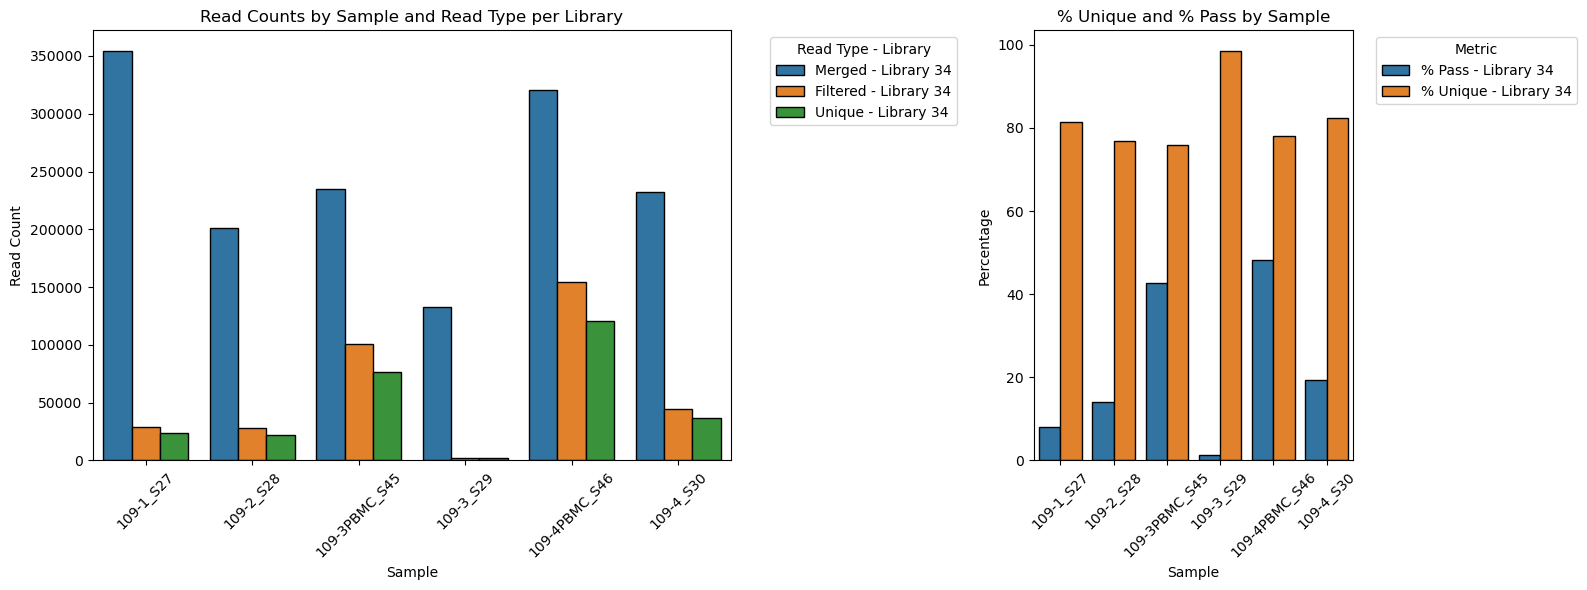

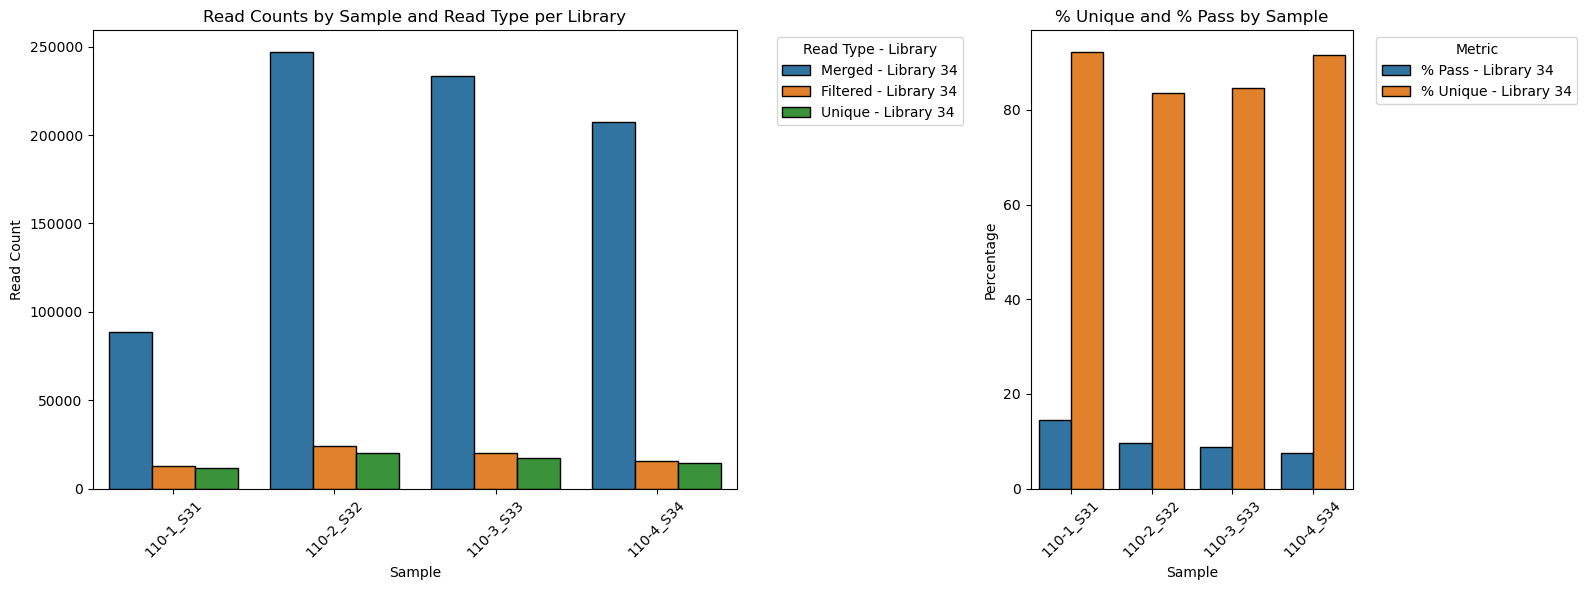

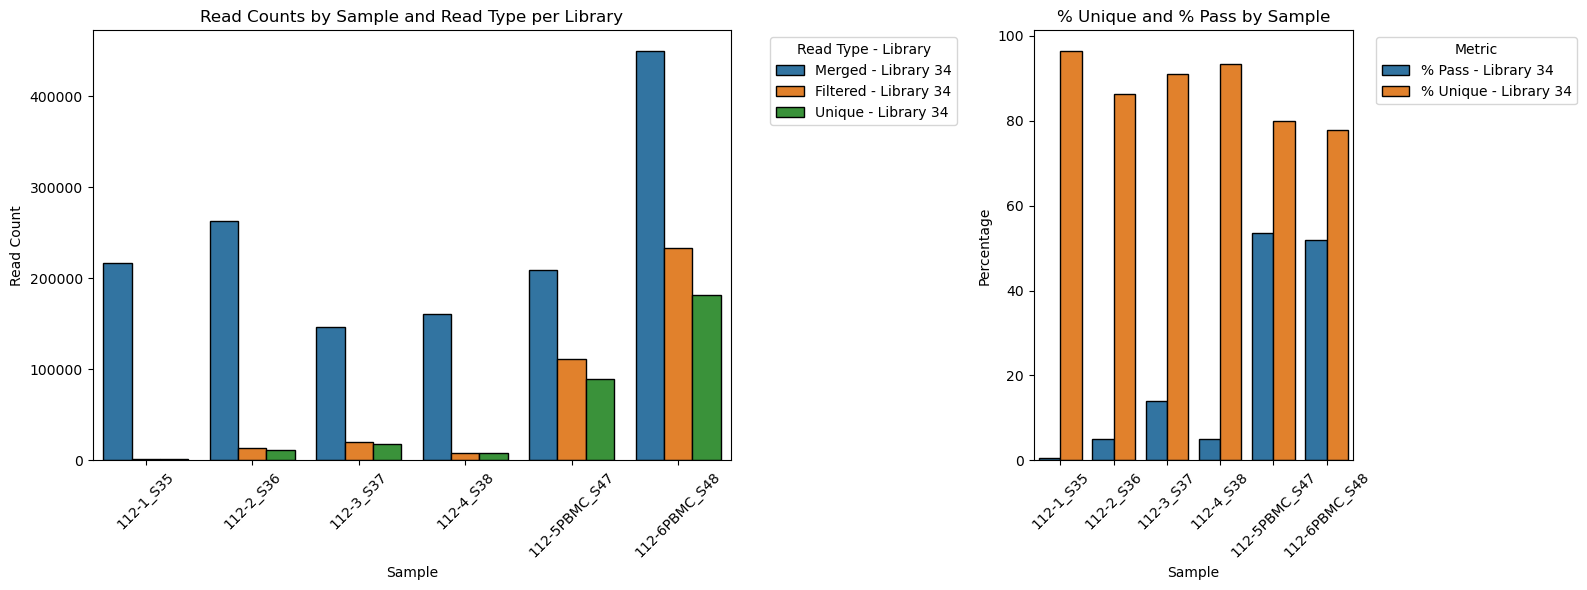

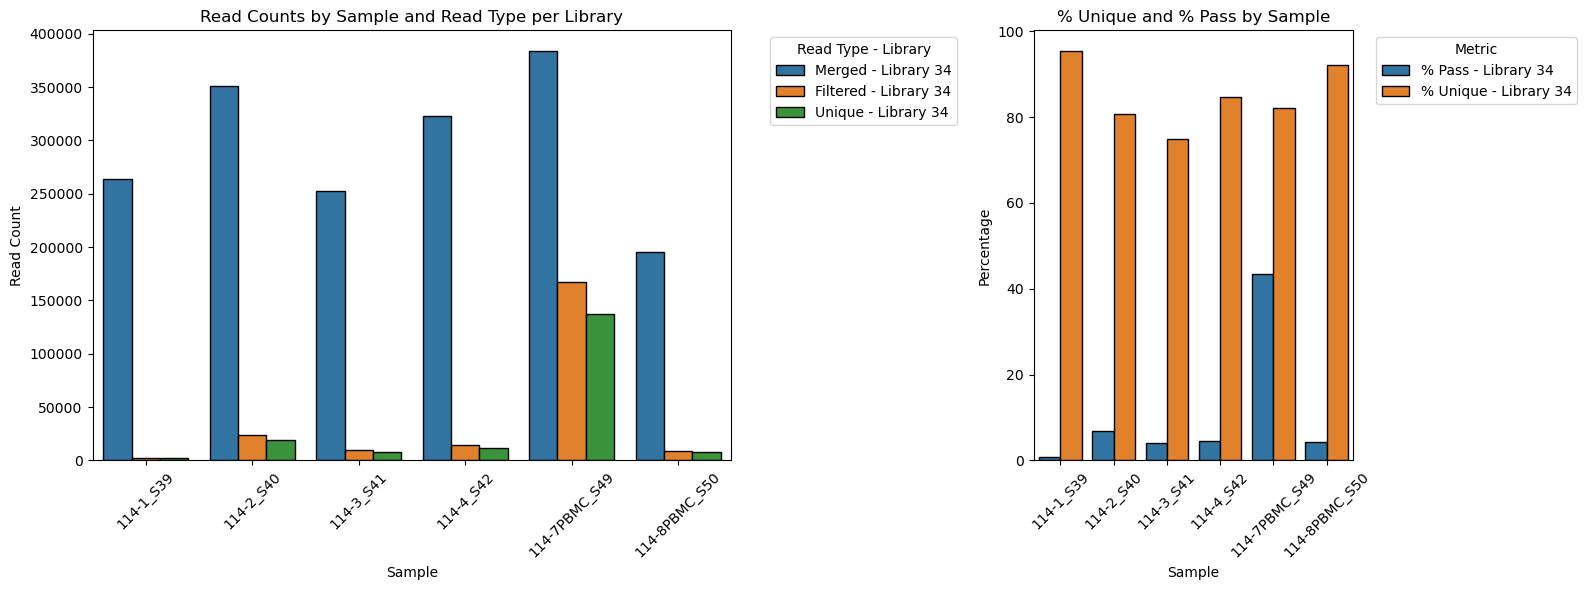

In [9]:
unique_patients = vdj_pipe_combined.patient_id.unique().tolist()
max_ylim = vdj_pipe_combined['merged reads'].max() + 1000
print(max_ylim)
for patient in unique_patients:
    samples = vdj_pipe_combined[vdj_pipe_combined.patient_id == patient]
    # Read counts melted
    df_long = pd.melt(samples, id_vars=['sample_snumber', 'library'], value_vars=['merged reads', 'filtered reads', 'unique reads'],
                        var_name='Read Type', value_name='Read Count' )
    
    df_long['Read Type'] = df_long['Read Type'].str.replace(' reads', '', regex=False).str.title()
    df_long['Library'] = df_long['library'].str.replace('_', ' ').str.title()
    df_long['Type-Library'] = df_long['Read Type'] + ' - ' + df_long['Library']

    # Percent metrics melted
    df_pct = pd.melt(samples,id_vars=['sample_snumber', 'library'], value_vars=['% Pass', '% Unique'], 
                     var_name='Metric', value_name='Percentage')
    df_pct['Library'] = df_pct['library'].str.replace('_', ' ').str.title()
    df_pct['Type-Library'] = df_pct['Metric'] + ' - ' + df_pct['Library']

    # Create figure with 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1.5]})
    # Plot Read Counts
    sns.barplot(data=df_long, x='sample_snumber', y='Read Count', hue='Type-Library', palette='tab10', edgecolor='black', ax=ax[0])
    ax[0].set_title('Read Counts by Sample and Read Type per Library')
    ax[0].set_xlabel('Sample')
    ax[0].set_ylabel('Read Count')
    # ax[0].set_ylim([10, max_ylim])
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].legend(title='Read Type - Library', bbox_to_anchor=(1.05, 1), loc='upper left')
    # Plot % Unique and % Pass
    sns.barplot(data=df_pct, x='sample_snumber', y='Percentage', hue='Type-Library', palette='tab10', edgecolor='black',ax=ax[1])
    ax[1].set_title('% Unique and % Pass by Sample')
    ax[1].set_xlabel('Sample')
    ax[1].set_ylabel('Percentage')
    # ax[1].set_ylim([10, 100])
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    # Save and show
    fig.tight_layout()
    figname = fig_dir + f'{patient}_read_count_with_library_and_percentages.png'
    plt.savefig(figname, bbox_inches='tight', dpi=300)
    plt.show()